
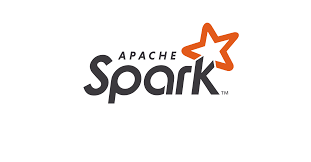

# Problem to solve: How to build the K-Means clustering model in Pyspark to perform customer segmentation on the e-commerce dataset

By the end of this lab, you will be familiar with the following concepts:

1. Reading csv files with PySpark
1. Exploratory Data Analysis with PySpark
1. Grouping and sorting data
1. Performing arithmetic operations
1. Aggregating datasets
1. Data Pre-Processing with PySpark
1. Working with datetime values
1. Type conversion
1. Joining two dataframes
1. The rank() function
1. PySpark Machine Learning
1. Creating a feature vector
1. Standardizing data
1. Building a K-Means clustering model
1. Interpreting the model


# Install pyspark

In [15]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Creating a SparkSession

A SparkSession is an entry point into all functionality in Spark, and is required if you want to build a dataframe in PySpark. Run the following lines of code to initialize a SparkSession.

Using the codes bellow, we built a spark session and set a name for the application. Then, the data was cached in off-heap memory to avoid storing it directly on disk, and the amount of memory was manually specified.

In [16]:
from pyspark.sql import SparkSession
import findspark

findspark.init()

spark = SparkSession.builder.appName("Datacamp Pyspark Tutorial")\
                    .config("spark.memory.offHeap.enabled","true")\
                    .config("spark.memory.offHeap.size","10g")\
                    .getOrCreate()

# Creating the DataFrame from a csv

In [17]:
# Download the data first into a local `OnlineRetail.csv` file

!curl https://raw.githubusercontent.com/antonioGoncalves64/pyspark/main/OnlineRetail.csv >> OnlineRetail.csv



df = spark.read.csv('OnlineRetail.csv',header=True,sep=";")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.4M  100 43.4M    0     0   112M      0 --:--:-- --:--:-- --:--:--  112M


# Look at the head of the dataframe

In [ ]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate     |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |01/12/2010 08:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |01/12/2010 08:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |01/12/2010 08:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |01/12/2010 08:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |01/12/2010 08:26|3.39     |17850     |United Kingdom|
+---------+---------+-------------------

# Exploratory Data Analysis

## Count the number of rows in the dataframe

In [ ]:
df.count()

225199

## Count how many unique customers are present in the dataframe

```
# This is formatted as code
```



In [ ]:
df.select('CustomerID').distinct().count()

2879

## What country do most purchases come from

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         2607|
|        Germany|           60|
|         France|           59|
|        Belgium|           20|
|          Spain|           20|
|    Switzerland|           12|
|       Portugal|           11|
|          Italy|           10|
|      Australia|            8|
|        Austria|            8|
|    Netherlands|            8|
|Channel Islands|            7|
|         Cyprus|            5|
|          Japan|            5|
|         Sweden|            4|
|        Finland|            4|
|        Denmark|            4|
|         Greece|            3|
|           EIRE|            3|
|         Norway|            3|
+---------------+-------------+
only showing top 20 rows



## When was the most recent purchase made by a customer on the e-commerce platform?

In [ ]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'dd/MM/yy HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-06-13 15:30:00|
+-------------------+



## When was the earliest purchase made by a customer on the e-commerce platform?

In [ ]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



# Data Pre-processing

Now that we have analyzed the dataset and have a better understanding of each data point, we need to prepare the data to feed into the machine learning algorithm.

we need to create multiple customer segments based on each user’s purchase behavior. 

The variables in this dataset are in a format that cannot be easily ingested into the customer segmentation model. These features individually do not tell us much about customer purchase behavior.

Due to this, we will use the existing variables to derive three new informative features - recency, frequency, and monetary value (RFM). RFM is commonly used in marketing to evaluate a client’s value based on their:

* Recency: How recently has each customer made a purchase?

* Frequency: How often have they bought something?

* Monetary Value: How much money do they spend on average when making purchases?

We will now preprocess the dataframe to create the above variables.

## Recency

First, let’s calculate the value of recency - the latest date and time a purchase was made on the platform. This can be achieved in two steps:

### Assign a recency score to each customer

We will subtract every date in the dataframe from the earliest date. This will tell us how recently a customer was seen in the dataframe. A value of 0 indicates the lowest recency, as it will be assigned to the person who was seen making a purchase on the earliest date.

In [ ]:
df = df.withColumn("from_date", lit("01/12/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'dd/MM/yy HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [ ]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [ ]:
df2.show(5,0)

+-------+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate     |UnitPrice|CustomerID|Country       |date               |from_date          |
+-------+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+-------------------+-------------------+
|5220   |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |01/12/2010 09:53|6.45     |18074     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|5220   |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |01/12/2010 09:53|0.65     |18074     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|5220   |536384   |22464    |HANGING METAL HEART LANTERN        |12      |01/12/2010 09:53|1.65     |18074     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08

In [ ]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



## Frequency

Let’s now calculate the value of frequency - how often a customer bought something on the platform. To do this, we just need to group by each customer ID and count the number of items they purchased:

In [ ]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|15574     |1        |
|17714     |10       |
|14157     |1        |
|16250     |10       |
|17551     |43       |
+----------+---------+
only showing top 5 rows



In [ ]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



### Monetary Value

Finally, let’s calculate monetary value - the total amount spent by each customer in the dataframe. There are two steps to achieving this:

* Find the total amount spent in each purchase
* Find the total amount spent by each customer

### Find the total amount spent in each purchase
Each customerID comes with variables called “Quantity” and “UnitPrice” for a single purchase. To get the total amount spent by each customer in one purchase, we need to multiply “Quantity” with “UnitPrice”

In [ ]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))



###Find the total amount spent by each customer. o find the total amount spent by each customer overall, we just need to group by the CustomerID column and sum the total amount spent

In [ ]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

Merge this dataframe with the all the other variables

In [ ]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')



In [ ]:
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

finaldf.show(5,0)

+-------+---------+--------------+----------+
|recency|frequency|monetary_value|CustomerID|
+-------+---------+--------------+----------+
|1311720|1        |3.75          |15574     |
|4586760|10       |153.0         |17714     |
|7627260|1        |-32.45        |14157     |
|9700860|10       |163.3         |16250     |
|1230360|43       |306.84        |17551     |
+-------+---------+--------------+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

data_scale_output.select('standardized').show(2,truncate=False)

+-------------------------------------------------------------+
|standardized                                                 |
+-------------------------------------------------------------+
|[0.2660268697875939,0.0420619382191303,0.0020464985893339184]|
|[0.9302300836054525,0.42061938219130296,0.08349714244482385] |
+-------------------------------------------------------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

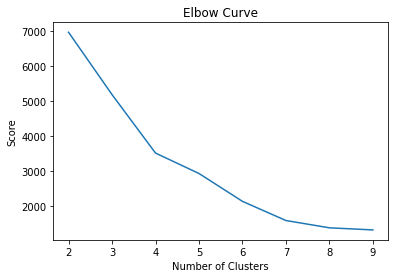

In [ ]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [ ]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+-------+---------+--------------+----------+-----------------------+-------------------------------------------------------------+----------+
|recency|frequency|monetary_value|CustomerID|features               |standardized                                                 |prediction|
+-------+---------+--------------+----------+-----------------------+-------------------------------------------------------------+----------+
|1311720|1        |3.75          |15574     |[1311720.0,1.0,3.75]   |[0.2660268697875939,0.0420619382191303,0.0020464985893339184]|0         |
|4586760|10       |153.0         |17714     |[4586760.0,10.0,153.0] |[0.9302300836054525,0.42061938219130296,0.08349714244482385] |0         |
|7627260|1        |-32.45        |14157     |[7627260.0,1.0,-32.45] |[1.5468667877718745,0.0420619382191303,-0.01770903445970284] |0         |
|9700860|10       |163.3         |16250     |[9700860.0,10.0,163.3] |[1.967408761052418,0.42061938219130296,0.0891181919035277]   |1         |

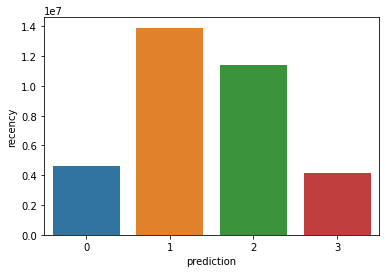

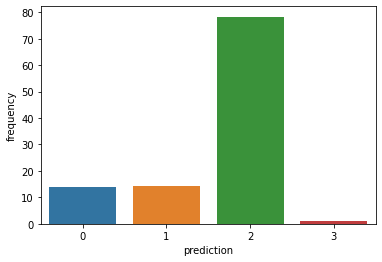

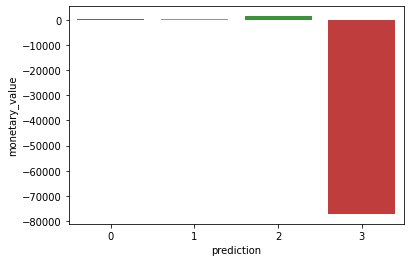

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()